In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as pyplot

from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from functools import reduce
from scipy import stats

from scipy.interpolate import griddata
import matplotlib.colors as colors

import numpy as np
import DataPreprocessing
import SmartPolynomials
import SplitDataSet

Using TensorFlow backend.


In [2]:
lmbda=-0.70853776
def transform(me):
    return (np.power(me + 1, lmbda) - 1)/lmbda
    #return (np.power(np.sign(me) + 1, np.sign(me)*(lmbda - 1) + 1) - 1)/(lmbda + np.sign(me) - 1)
def inverse(temp):
    return np.power(lmbda*temp + 1, 1/lmbda) - 1
    #return - 1 + np.sign(temp)*np.power((np.sign(temp) - 1 + lmbda)*temp + 1, 1/(np.sign(temp)*(lmbda - 1) + 1))
def inverse_tf(temp):
    return tf.pow(lmbda*temp + 1, 1/lmbda) - 1
    #return - 1 + tf.sign(temp)*tf.pow((tf.sign(temp) - 1 + lmbda)*temp + 1, 1/(tf.sign(temp)*(lmbda - 1) + 1))
def frac_error(true, experimental):
    return np.abs(np.divide(inverse(true) - inverse(experimental), inverse(true)))

In [16]:
def perc_error(true, experimental):
    return 100*tf.abs(tf.divide(inverse_tf(true) - inverse_tf(experimental), inverse_tf(true)))

def build_model(components=200, activation='elu'):
    #activation = keras.
    model = keras.Sequential([
        keras.layers.Dense(components, activation=activation, input_shape=[8]), #could try swish??  
        keras.layers.Dense(components - 100, activation=activation),
        keras.layers.Dense(components - 150, activation=activation),
        keras.layers.Dense(1, activation='linear') 
    ])

    adam = tf.keras.optimizers.Adam(0.00005)
    model.compile(loss='mse', 
                optimizer=adam, metrics=['mape',perc_error])
    return model

In [9]:
def calc_RMSE(mom_train, mom_test, rescaled_train, rescaled_test, reuse_model=False):
    if reuse_model:
        model = build_model()
        model.load_weights("LO/MODEL/uuxg.hdf5")
    else:
        model = build_model()
    
    temp_train = rescaled_train
    temp_test = rescaled_test
    
    scaler = StandardScaler()

    poly_train = np.array([np.ndarray.flatten(np.array(element)) for element in mom_train[:,1:]])
    poly_test = np.array([np.ndarray.flatten(np.array(element)) for element in mom_test[:,1:]])
    poly_train = scaler.fit_transform(poly_train) #Rescale on training set
    poly_test = scaler.transform(poly_test)

    
        # Saves the best model's weights
    checkpoint_path = "LO/MODEL/uuxg.hdf5"
    callback_a = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_best_only=True)
    callback_b = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
    history = model.fit(poly_train, temp_train, batch_size=256, epochs=1000, 
                        shuffle=True, verbose=1, callbacks=[callback_b, callback_a],
                       validation_data=(poly_test, temp_test))


    try:
        # load the saved model
        saved_model = build_model()
        saved_model.load_weights(checkpoint_path)
        
        
        train_predict = saved_model.predict(poly_train)
        train_predict.shape = (len(train_predict))  
        train_perc = 100*np.mean(np.abs((temp_train - train_predict) / temp_train))
        train_error = 100*np.mean(frac_error(temp_train, train_predict))                                 
        
        test_predict = saved_model.predict(poly_test)
        test_predict.shape = (len(test_predict))
        test_perc = 100*np.mean(np.abs((temp_test - test_predict) / temp_test))
        test_error = 100*np.mean(frac_error(temp_test, test_predict))

        print('Train: %.3f, Test: %.3f' % (train_perc, test_perc))
        print('Train: %.3f, Test: %.3f' % (train_error, test_error))
        
        #return(train_error, test_error, born_error(temp_test, test_predict, rescaled_test[:,0]), history)
        return(train_error, test_error, temp_test**2 - test_predict**2, history)
    except ValueError:
        print('Value Error Encountered')       
    return(0, 0, 0, 0)

In [14]:
##Obtain & process data NPY
me_train, mom_train = SplitDataSet.smallestS('LO/MG_uuxg_2/me_1000000.npy', 'LO/MG_uuxg_2/mom_1000000.npy', 1)
me_test, mom_test = SplitDataSet.smallestS('LO/MG_uuxg_2/me_100000.npy', 'LO/MG_uuxg_2/mom_100000.npy', 1)

print(me_train.shape)
div_train = reduce(np.multiply, DataPreprocessing.mandel_creation(['1,3','2,3'], mom_train))
div_test = reduce(np.multiply, DataPreprocessing.mandel_creation(['1,3','2,3'], mom_test))
    
temp_train = np.multiply(div_train, me_train)
temp_test = np.multiply(div_test, me_test)

std = np.std(temp_train)
temp_train = transform(temp_train/std)
temp_test = transform(temp_test/std)

(334366,)


In [17]:
print('Std : {}'.format(np.std(temp_train)))
print('Mean : {}'.format(np.mean(temp_train)))

train, test, perc, history = calc_RMSE(mom_train, mom_test, temp_train, temp_test, reuse_model=True)

Std : 0.07594040214534281
Mean : 0.8939618724645176
Train on 334366 samples, validate on 33271 samples
Epoch 1/1000
334366/334366 [==============================]334366/334366 [==============================] - 5s 15us/step - loss: 2.6995e-07 - mean_absolute_percentage_error: 0.0404 - perc_error: 0.1302 - val_loss: 4.2118e-07 - val_mean_absolute_percentage_error: 0.0599 - val_perc_error: 0.1964

Epoch 2/1000
334366/334366 [==============================]334366/334366 [==============================] - 4s 13us/step - loss: 2.1943e-07 - mean_absolute_percentage_error: 0.0418 - perc_error: 0.1355 - val_loss: 3.7156e-07 - val_mean_absolute_percentage_error: 0.0558 - val_perc_error: 0.1808

Epoch 3/1000
334366/334366 [==============================]334366/334366 [==============================] - 4s 12us/step - loss: 2.1735e-07 - mean_absolute_percentage_error: 0.0417 - perc_error: 0.1350 - val_loss: 2.3499e-07 - val_mean_absolute_percentage_error: 0.0441 - val_perc_error: 0.1396

Epoch 4/1

334366/334366 [==============================]334366/334366 [==============================] - 4s 12us/step - loss: 1.9272e-07 - mean_absolute_percentage_error: 0.0391 - perc_error: 0.1269 - val_loss: 2.7111e-07 - val_mean_absolute_percentage_error: 0.0465 - val_perc_error: 0.1454

Epoch 29/1000
334366/334366 [==============================]334366/334366 [==============================] - 4s 12us/step - loss: 2.0840e-07 - mean_absolute_percentage_error: 0.0406 - perc_error: 0.1320 - val_loss: 2.3279e-07 - val_mean_absolute_percentage_error: 0.0438 - val_perc_error: 0.1399

Epoch 30/1000
334366/334366 [==============================]334366/334366 [==============================] - 4s 12us/step - loss: 1.8739e-07 - mean_absolute_percentage_error: 0.0387 - perc_error: 0.1255 - val_loss: 2.6935e-07 - val_mean_absolute_percentage_error: 0.0468 - val_perc_error: 0.1542

Epoch 31/1000
334366/334366 [==============================]334366/334366 [==============================] - 4s 12us/step -

In [9]:
print(training_error)

NameError: name 'training_error' is not defined

In [8]:
print(test_error)

0.9621650993422035


In [24]:
print(perc_error)

23.910728432260218


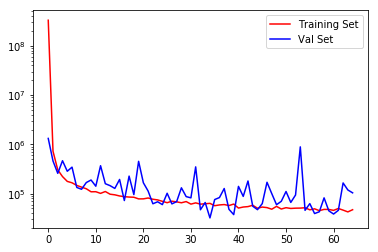

In [7]:
points = len(history.history['loss'])
pyplot.plot(range(points), history.history['loss'], color='r', label='Training Set')
pyplot.plot(range(points), history.history['val_loss'],color='b', label='Val Set')
pyplot.legend()
#pyplot.ylim(0,2)
pyplot.yscale('log')

In [ ]:
np.divide(np.abs(me_test - me_predict), me_test)

